In [1]:
import MLMarker_app
import pandas as pd
import numpy as np
from MLMarker_app import MLMarker
import matplotlib.pyplot as plt
import random
import seaborn as sns

/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


# 1. Comparison of the three datasets  
Provide MLMarker with the complete set of proteins detected in the three different sample preps and study differences in predictions.  

In general: 
All samples show a testis as a very likely tissue. This is often observed in samples containing a lot of secretion, etc.  
Evo96 and proteochipD0 showed more similar prediction patterns compared to the proteochipPFA.  ==> follow up analysis, which proteins are different?   
Evo96 and proteochipD0 both show Retina, a neuronal-like tissue with high probability which is promising!  

In [2]:
protein_lists = []
for i in ['evo96_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_PFA_report_organoides_042024_fixes.pg_matrix.tsv']:    
    df = pd.read_csv(i, sep='\t')
    proteins = np.array(df[["Protein.Ids"]].values.tolist()).flatten()
    # if it contains ';' split it and take both
    proteins = [x.split(';') for x in proteins]
    proteins = [item for sublist in proteins for item in sublist]
    proteins = list(set(proteins))
    print(i, len(proteins))
    protein_lists.append(set(proteins))
    #make a dataframe with the proteins as column names, only one row and all values 1
    data = np.ones((1, len(proteins)))
    predict_df = pd.DataFrame(data, columns=proteins)
    test = MLMarker(predict_df.iloc[0:1,:], binary = True)
    prediction = MLMarker.adjusted_shap_values_df(test, penalty_factor=0.5)
    prediction = prediction.sum(axis=1).sort_values(ascending=False).head(6)
    print(i, prediction)

evo96_report_organoids_culture_15042024_diann181.pg_matrix.tsv 2764
evo96_report_organoids_culture_15042024_diann181.pg_matrix.tsv tissue
Testis           0.146746
Retina           0.123696
Esophagus        0.021704
Parotid gland    0.021241
NK-cells         0.008798
Lymph node       0.000000
dtype: float64
proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv 3951
proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv tissue
Retina             0.158599
Testis             0.132816
Esophagus          0.060631
Skeletal muscle    0.029214
Adipose tissue     0.015411
NK-cells           0.000000
dtype: float64
proteochip_PFA_report_organoides_042024_fixes.pg_matrix.tsv 861
proteochip_PFA_report_organoides_042024_fixes.pg_matrix.tsv tissue
Testis       0.133897
Esophagus    0.087843
Prostate     0.057255
Ureter       0.018408
NK-cells     0.000000
Tonsil       0.000000
dtype: float64


A standard PCA plot of proteins shows little difference between PFA and the others

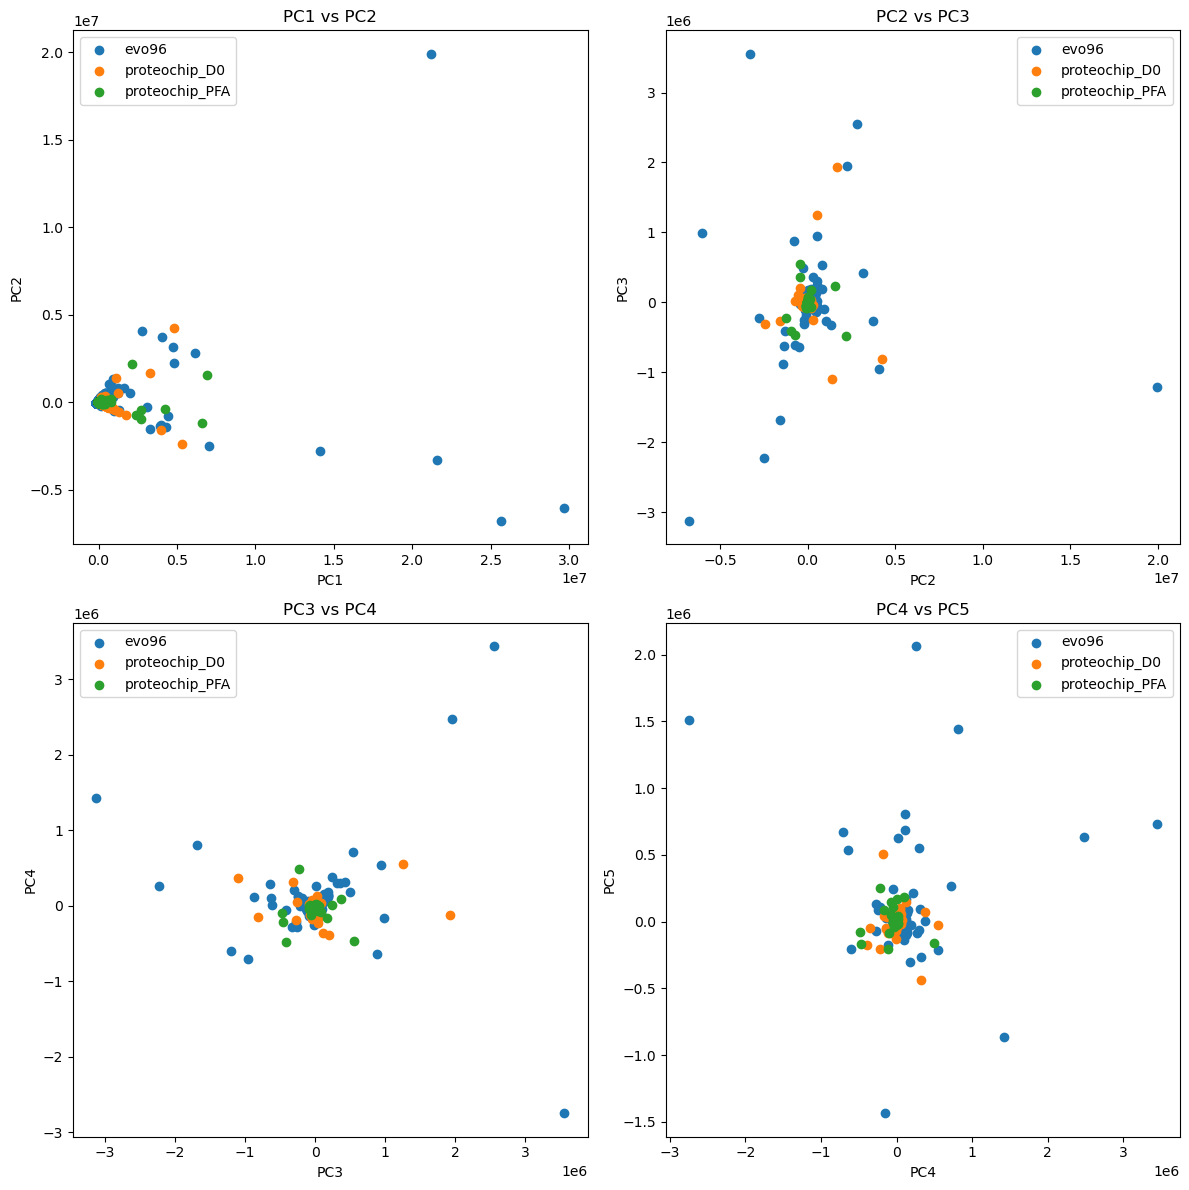

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

datasets = ['evo96_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_PFA_report_organoides_042024_fixes.pg_matrix.tsv']
names = ['evo96', 'proteochip_D0', 'proteochip_PFA']

# Create a figure and axes
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Iterate over each dataset
for name, dataset in zip(names, datasets):
    # Read the data
    df = pd.read_csv(dataset, sep='\t')
    data = df.iloc[:, 5:].fillna(0).values
    
    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=5)
    reduced_data = pca.fit_transform(data)
    
    # Plot the reduced data with color based on the dataset
    axs[0, 0].scatter(reduced_data[:, 0], reduced_data[:, 1], label=name)
    axs[0, 1].scatter(reduced_data[:, 1], reduced_data[:, 2], label=name)
    axs[1, 0].scatter(reduced_data[:, 2], reduced_data[:, 3], label=name)
    axs[1, 1].scatter(reduced_data[:, 3], reduced_data[:, 4], label=name)

# Add labels and titles for each subplot
axs[0, 0].set_title('PC1 vs PC2')
axs[0, 0].set_xlabel('PC1')
axs[0, 0].set_ylabel('PC2')
axs[0, 0].legend()

axs[0, 1].set_title('PC2 vs PC3')
axs[0, 1].set_xlabel('PC2')
axs[0, 1].set_ylabel('PC3')
axs[0, 1].legend()

axs[1, 0].set_title('PC3 vs PC4')
axs[1, 0].set_xlabel('PC3')
axs[1, 0].set_ylabel('PC4')
axs[1, 0].legend()

axs[1, 1].set_title('PC4 vs PC5')
axs[1, 1].set_xlabel('PC4')
axs[1, 1].set_ylabel('PC5')
axs[1, 1].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


PCA on the predictions, not on the proteins shows a different pattern

In [4]:
import tqdm as tqdm

datasets = ['evo96_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_PFA_report_organoides_042024_fixes.pg_matrix.tsv']
names = ['evo96', 'proteochip_D0', 'proteochip_PFA']
# Create a new dataframe to store the predictions
prediction_df = pd.DataFrame(columns=['dataset', 'sample', 'n_proteins', 'Testis',  'Retina',  'Parotid gland',  'Brain',  'Adipose tissue',  'Prostate',  'NK-cells',  'Skeletal muscle',  'Urinary bladder',  'B-cells',  'Esophagus',  'T-cells',  'Ureter',  'Lymph node',  'Gall bladder',  'Tonsil',  'Placenta',  'Liver',  'Appendix',  'Heart',  'Small intestine',  'Adrenal gland',  'Colon',  'Ovary'])

for name, dataset in zip(names, datasets):
    print(f"started on {name}")
    df = pd.read_csv(dataset, sep='\t')
    df['Protein.Ids'] = df['Protein.Ids'].astype(str).str.split(';').str[0]
    sub_df = df.set_index('Protein.Ids')
    sub_df.drop(columns=['Protein.Group', 'Protein.Names', 'Genes', 'First.Protein.Description'], inplace=True)
    sub_df = sub_df.T
    sub_df.fillna(0, inplace=True)
    sub_df = sub_df.astype(float)

    # Iterate over each row in sub_df
    for i in tqdm.tqdm(range(sub_df.shape[0])):
        test = MLMarker(sub_df.iloc[i:i+1,:], binary=True)
        prediction = MLMarker.adjusted_shap_values_df(test, n_preds=100, penalty_factor=0.5).sum(axis=1).sort_values(ascending=False)
        prediction = list(prediction.items())
        new_name = str(name) + "_" + str(sub_df.index[i])
        num_nonzero_columns = (sub_df.iloc[i:i+1,:] != 0).sum(axis=1).values[0]
        num_nonzero_columns
        # Create a new row in prediction_df
        prediction_df = pd.concat([prediction_df, pd.DataFrame({'dataset': [name], 'sample': [new_name], 'n_proteins': [num_nonzero_columns]})], ignore_index=True)
        
        # Add the predictions to the new row
        for tissue, prob in prediction:
            prediction_df.loc[prediction_df.index[-1], tissue] = prob


started on evo96


  0%|          | 0/35 [00:00<?, ?it/s]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


  3%|▎         | 1/35 [00:02<01:19,  2.32s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


  6%|▌         | 2/35 [00:04<01:14,  2.26s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


  9%|▊         | 3/35 [00:06<01:11,  2.24s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 11%|█▏        | 4/35 [00:09<01:10,  2.26s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 14%|█▍        | 5/35 [00:11<01:07,  2.26s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 17%|█▋        | 6/35 [00:13<01:05,  2.24s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 20%|██        | 7/35 [00:15<01:02,  2.23s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 23%|██▎       | 8/35 [00:17<01:00,  2.23s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 26%|██▌       | 9/35 [00:20<00:57,  2.23s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 29%|██▊       | 10/35 [00:22<00:56,  2.25s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 31%|███▏      | 11/35 [00:24<00:54,  2.28s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 34%|███▍      | 12/35 [00:27<00:52,  2.27s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 37%|███▋      | 13/35 [00:29<00:49,  2.26s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 40%|████      | 14/35 [00:31<00:47,  2.28s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 43%|████▎     | 15/35 [00:33<00:45,  2.27s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 46%|████▌     | 16/35 [00:36<00:43,  2.26s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 49%|████▊     | 17/35 [00:38<00:40,  2.25s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 51%|█████▏    | 18/35 [00:40<00:38,  2.25s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 54%|█████▍    | 19/35 [00:42<00:36,  2.25s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 57%|█████▋    | 20/35 [00:45<00:34,  2.29s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 60%|██████    | 21/35 [00:47<00:31,  2.28s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 63%|██████▎   | 22/35 [00:49<00:29,  2.26s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 66%|██████▌   | 23/35 [00:51<00:27,  2.26s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 69%|██████▊   | 24/35 [00:54<00:24,  2.25s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 71%|███████▏  | 25/35 [00:56<00:22,  2.25s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 74%|███████▍  | 26/35 [00:58<00:20,  2.25s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 77%|███████▋  | 27/35 [01:00<00:18,  2.26s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 80%|████████  | 28/35 [01:03<00:15,  2.26s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 83%|████████▎ | 29/35 [01:05<00:13,  2.26s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 86%|████████▌ | 30/35 [01:07<00:11,  2.29s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 89%|████████▊ | 31/35 [01:10<00:09,  2.28s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 91%|█████████▏| 32/35 [01:12<00:06,  2.27s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 94%|█████████▍| 33/35 [01:14<00:04,  2.26s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 97%|█████████▋| 34/35 [01:16<00:02,  2.26s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


100%|██████████| 35/35 [01:19<00:00,  2.26s/it]


started on proteochip_D0


  0%|          | 0/44 [00:00<?, ?it/s]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


  2%|▏         | 1/44 [00:02<02:06,  2.95s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


  5%|▍         | 2/44 [00:05<02:02,  2.91s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


  7%|▋         | 3/44 [00:08<02:01,  2.97s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


  9%|▉         | 4/44 [00:11<01:58,  2.96s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 11%|█▏        | 5/44 [00:14<01:55,  2.96s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 14%|█▎        | 6/44 [00:17<01:51,  2.94s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 16%|█▌        | 7/44 [00:20<01:48,  2.94s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 18%|█▊        | 8/44 [00:23<01:46,  2.97s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 20%|██        | 9/44 [00:26<01:43,  2.95s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 23%|██▎       | 10/44 [00:29<01:40,  2.95s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 25%|██▌       | 11/44 [00:32<01:37,  2.94s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 27%|██▋       | 12/44 [00:35<01:34,  2.95s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 30%|██▉       | 13/44 [00:38<01:32,  2.99s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 32%|███▏      | 14/44 [00:41<01:29,  2.98s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 34%|███▍      | 15/44 [00:44<01:25,  2.96s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 36%|███▋      | 16/44 [00:47<01:22,  2.96s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 39%|███▊      | 17/44 [00:50<01:19,  2.94s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 41%|████      | 18/44 [00:53<01:16,  2.93s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 43%|████▎     | 19/44 [00:56<01:13,  2.93s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 45%|████▌     | 20/44 [00:58<01:10,  2.93s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 48%|████▊     | 21/44 [01:01<01:07,  2.94s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 50%|█████     | 22/44 [01:05<01:05,  2.99s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 52%|█████▏    | 23/44 [01:07<01:02,  2.97s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 55%|█████▍    | 24/44 [01:10<00:59,  2.97s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 57%|█████▋    | 25/44 [01:13<00:56,  2.97s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 59%|█████▉    | 26/44 [01:16<00:53,  2.97s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 61%|██████▏   | 27/44 [01:19<00:50,  2.97s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 64%|██████▎   | 28/44 [01:22<00:47,  2.96s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 66%|██████▌   | 29/44 [01:25<00:44,  2.96s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 68%|██████▊   | 30/44 [01:28<00:41,  2.94s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 70%|███████   | 31/44 [01:31<00:38,  2.99s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 73%|███████▎  | 32/44 [01:34<00:35,  2.99s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 75%|███████▌  | 33/44 [01:37<00:32,  2.98s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 77%|███████▋  | 34/44 [01:40<00:29,  2.98s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 80%|███████▉  | 35/44 [01:43<00:26,  2.97s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 82%|████████▏ | 36/44 [01:46<00:23,  2.97s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 84%|████████▍ | 37/44 [01:49<00:20,  2.96s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 86%|████████▋ | 38/44 [01:52<00:17,  2.96s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 89%|████████▊ | 39/44 [01:55<00:14,  2.95s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 91%|█████████ | 40/44 [01:58<00:12,  3.00s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 93%|█████████▎| 41/44 [02:01<00:08,  2.99s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 95%|█████████▌| 42/44 [02:04<00:05,  2.98s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 98%|█████████▊| 43/44 [02:07<00:02,  2.97s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


100%|██████████| 44/44 [02:10<00:00,  2.96s/it]


started on proteochip_PFA


  0%|          | 0/41 [00:00<?, ?it/s]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


  2%|▏         | 1/41 [00:01<00:55,  1.40s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


  5%|▍         | 2/41 [00:02<00:54,  1.40s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


  7%|▋         | 3/41 [00:04<00:53,  1.41s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 10%|▉         | 4/41 [00:05<00:51,  1.40s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 12%|█▏        | 5/41 [00:06<00:50,  1.39s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 15%|█▍        | 6/41 [00:08<00:48,  1.38s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 17%|█▋        | 7/41 [00:09<00:48,  1.43s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 20%|█▉        | 8/41 [00:11<00:46,  1.42s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 22%|██▏       | 9/41 [00:12<00:45,  1.41s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 24%|██▍       | 10/41 [00:14<00:43,  1.41s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 27%|██▋       | 11/41 [00:15<00:42,  1.40s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 29%|██▉       | 12/41 [00:16<00:40,  1.41s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 32%|███▏      | 13/41 [00:18<00:39,  1.39s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 34%|███▍      | 14/41 [00:19<00:37,  1.39s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 37%|███▋      | 15/41 [00:21<00:36,  1.40s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 39%|███▉      | 16/41 [00:22<00:34,  1.39s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 41%|████▏     | 17/41 [00:23<00:34,  1.43s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 44%|████▍     | 18/41 [00:25<00:32,  1.42s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 46%|████▋     | 19/41 [00:26<00:30,  1.41s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 49%|████▉     | 20/41 [00:28<00:29,  1.40s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 51%|█████     | 21/41 [00:29<00:28,  1.40s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 54%|█████▎    | 22/41 [00:30<00:26,  1.40s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 56%|█████▌    | 23/41 [00:32<00:25,  1.40s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 59%|█████▊    | 24/41 [00:33<00:23,  1.40s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 61%|██████    | 25/41 [00:35<00:22,  1.40s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 63%|██████▎   | 26/41 [00:36<00:21,  1.41s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 66%|██████▌   | 27/41 [00:38<00:20,  1.44s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 68%|██████▊   | 28/41 [00:39<00:18,  1.42s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 71%|███████   | 29/41 [00:40<00:16,  1.41s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 73%|███████▎  | 30/41 [00:42<00:15,  1.41s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 76%|███████▌  | 31/41 [00:43<00:14,  1.40s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 78%|███████▊  | 32/41 [00:44<00:12,  1.40s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 80%|████████  | 33/41 [00:46<00:11,  1.40s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 83%|████████▎ | 34/41 [00:47<00:09,  1.40s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 85%|████████▌ | 35/41 [00:49<00:08,  1.40s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 88%|████████▊ | 36/41 [00:50<00:06,  1.39s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 90%|█████████ | 37/41 [00:52<00:05,  1.43s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 93%|█████████▎| 38/41 [00:53<00:04,  1.42s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 95%|█████████▌| 39/41 [00:54<00:02,  1.40s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 98%|█████████▊| 40/41 [00:56<00:01,  1.40s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


100%|██████████| 41/41 [00:57<00:00,  1.40s/it]


In [5]:
prediction_df.head()

,dataset,sample,n_proteins,Testis,Retina,Parotid gland,Brain,Adipose tissue,Prostate,NK-cells,...,Gall bladder,Tonsil,Placenta,Liver,Appendix,Heart,Small intestine,Adrenal gland,Colon,Ovary
0,evo96,evo96_TU014944PAP_Slot1-12_1_3201.d,1617,0.069722,0.02945,0.02428,-0.00947,0.015863,-0.007772,0.040735,...,-0.010231,-0.006685,-0.005813,-0.018095,-0.004986,-0.016222,-0.013609,-0.022973,-0.032618,-0.037687
1,evo96,evo96_TU014945PAP_Slot1-11_1_3202.d,1990,0.094767,0.046844,0.035649,-0.006284,0.013173,-0.007236,0.028412,...,-0.009938,-0.016868,-0.009034,-0.014349,-0.014278,-0.011671,-0.015727,-0.022728,-0.032774,-0.036607
2,evo96,evo96_TU014946PAP_Slot1-10_1_3203.d,1719,0.09668,0.054686,0.036671,-0.008882,0.014954,-0.006392,0.008809,...,-0.011259,-0.014729,-0.018402,-0.013949,-0.01257,-0.009976,-0.015796,-0.022584,-0.030169,-0.035417
3,evo96,evo96_TU014947PAP_Slot1-09_1_3204.d,1530,0.066801,0.051131,0.037065,-0.005124,0.013626,-0.005958,0.012646,...,-0.00922,-0.019204,-0.012139,-0.014756,-0.010493,-0.010742,-0.014357,-0.019862,-0.032121,-0.032039
4,evo96,evo96_TU014948PAP_Slot1-08_1_3205.d,1589,0.057079,0.02959,0.040697,-0.005137,0.005769,-0.005695,0.019478,...,-0.010429,-0.005921,-0.009272,-0.014096,-0.008364,-0.010554,-0.013714,-0.018135,-0.032382,-0.030176


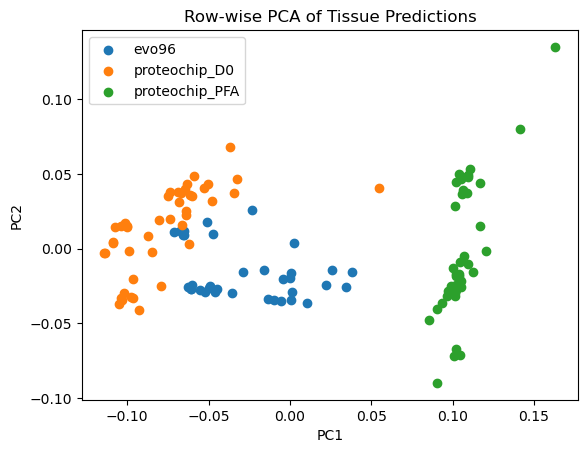

In [6]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(prediction_df.drop(columns=['sample', 'dataset', 'n_proteins']))

# Create a figure and axis
fig, ax = plt.subplots()

# Iterate over each dataset
for name, dataset in zip(names, datasets):
    # Get the indices of samples from the current dataset
    indices = prediction_df[prediction_df['dataset'] == name].index
    
    # Plot the reduced data with color based on the dataset
    ax.scatter(reduced_data[indices, 0], reduced_data[indices, 1], label=name)

# Add labels and title
ax.set_title('Row-wise PCA of Tissue Predictions')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()

# Show the plot
plt.show()


Is this because of a difference in the number of proteins (and consequentially missing values in the predictor)

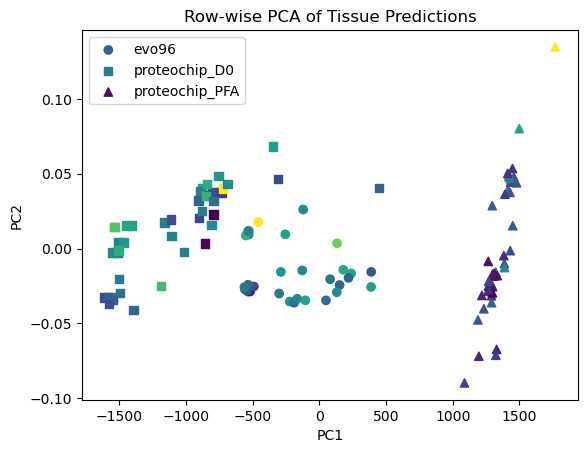

In [10]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(prediction_df.drop(columns=['sample', 'dataset', 'Brain']))

# Create a figure and axis
fig, ax = plt.subplots()

# Iterate over each dataset
for name, dataset in zip(names, datasets):
    # Get the indices of samples from the current dataset
    indices = prediction_df[prediction_df['dataset'] == name].index
    
    # Get the number of proteins for each sample
    n_proteins = prediction_df.loc[indices, 'Brain']
    
    # Set the marker type based on the dataset
    marker = 'o' if name == 'evo96' else 's' if name == 'proteochip_D0' else '^'
    
    # Plot the reduced data with color and marker type
    ax.scatter(reduced_data[indices, 0], reduced_data[indices, 1], c=n_proteins, marker=marker, label=name)

# Add labels and title
ax.set_title('Row-wise PCA of Tissue Predictions')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()

# Show the plot
plt.show()


So, the protein PCA does not show tremendous differences but the predictions do!  
This can be caused by the fact that MLMarker looks at less proteins than are present within the sample and maybe those are just different? Let's remake the protein PCA with only those proteins

In [8]:
features_path = "/home/compomics/git/MLMarker/models/binary_features_TP_4000features_95to75missingness_2024.txt"
with open(features_path, 'r') as features_file:
    features = features_file.read().split(',\n')


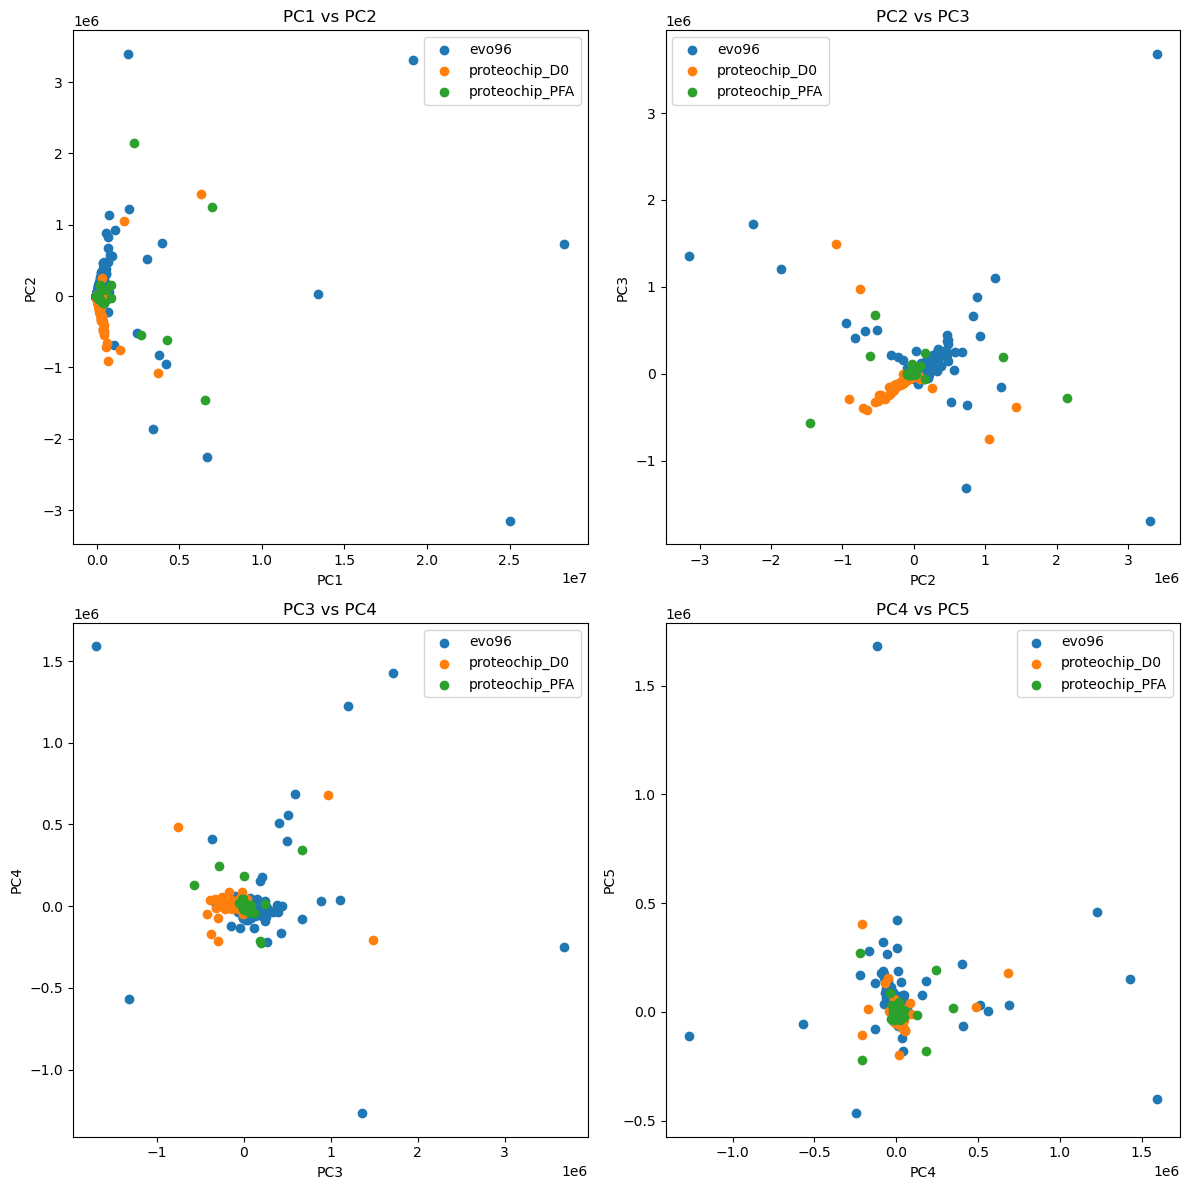

In [9]:
#PCA with MLMarker features

datasets = ['evo96_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_PFA_report_organoides_042024_fixes.pg_matrix.tsv']
names = ['evo96', 'proteochip_D0', 'proteochip_PFA']

# Create a figure and axes
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Iterate over each dataset
for name, dataset in zip(names, datasets):
    # Read the data
    df = pd.read_csv(dataset, sep='\t')
    df['Protein.Ids'] = df['Protein.Ids'].astype(str).str.split(';').str[0]
    df = df[df['Protein.Ids'].isin(features)] #only use the MLMarker proteins
    #add the missing proteins with 0 values
    missing_proteins = list(set(features) - set(df['Protein.Ids']))
    #add the missing proteins to the protein.ids column with zero values across the whole row
    df = pd.concat([df, pd.DataFrame(np.zeros((len(missing_proteins), df.shape[1])), columns=df.columns.tolist())])
    df = df.set_index('Protein.Ids')
    data = df.iloc[:, 5:].fillna(0).values
    
    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=5)
    reduced_data = pca.fit_transform(data)
    
    # Plot the reduced data with color based on the dataset
    axs[0, 0].scatter(reduced_data[:, 0], reduced_data[:, 1], label=name)
    axs[0, 1].scatter(reduced_data[:, 1], reduced_data[:, 2], label=name)
    axs[1, 0].scatter(reduced_data[:, 2], reduced_data[:, 3], label=name)
    axs[1, 1].scatter(reduced_data[:, 3], reduced_data[:, 4], label=name)

# Add labels and titles for each subplot
axs[0, 0].set_title('PC1 vs PC2')
axs[0, 0].set_xlabel('PC1')
axs[0, 0].set_ylabel('PC2')
axs[0, 0].legend()

axs[0, 1].set_title('PC2 vs PC3')
axs[0, 1].set_xlabel('PC2')
axs[0, 1].set_ylabel('PC3')
axs[0, 1].legend()

axs[1, 0].set_title('PC3 vs PC4')
axs[1, 0].set_xlabel('PC3')
axs[1, 0].set_ylabel('PC4')
axs[1, 0].legend()

axs[1, 1].set_title('PC4 vs PC5')
axs[1, 1].set_xlabel('PC4')
axs[1, 1].set_ylabel('PC5')
axs[1, 1].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


There is no such difference from PFA on a protein level even with only the trained proteins (from which the missing ones are added as zero values).  
The most logical solution for this is that the lower amount of proteins within PFA impacts the prediction a lot which is not visible within the proteinlevel PCA.

This means that the MLMarker can detect levels at the proteome level which are not visible from the individual proteins. MLMarker is binary so it's also not a matter of higher or lower expressed proteins!  


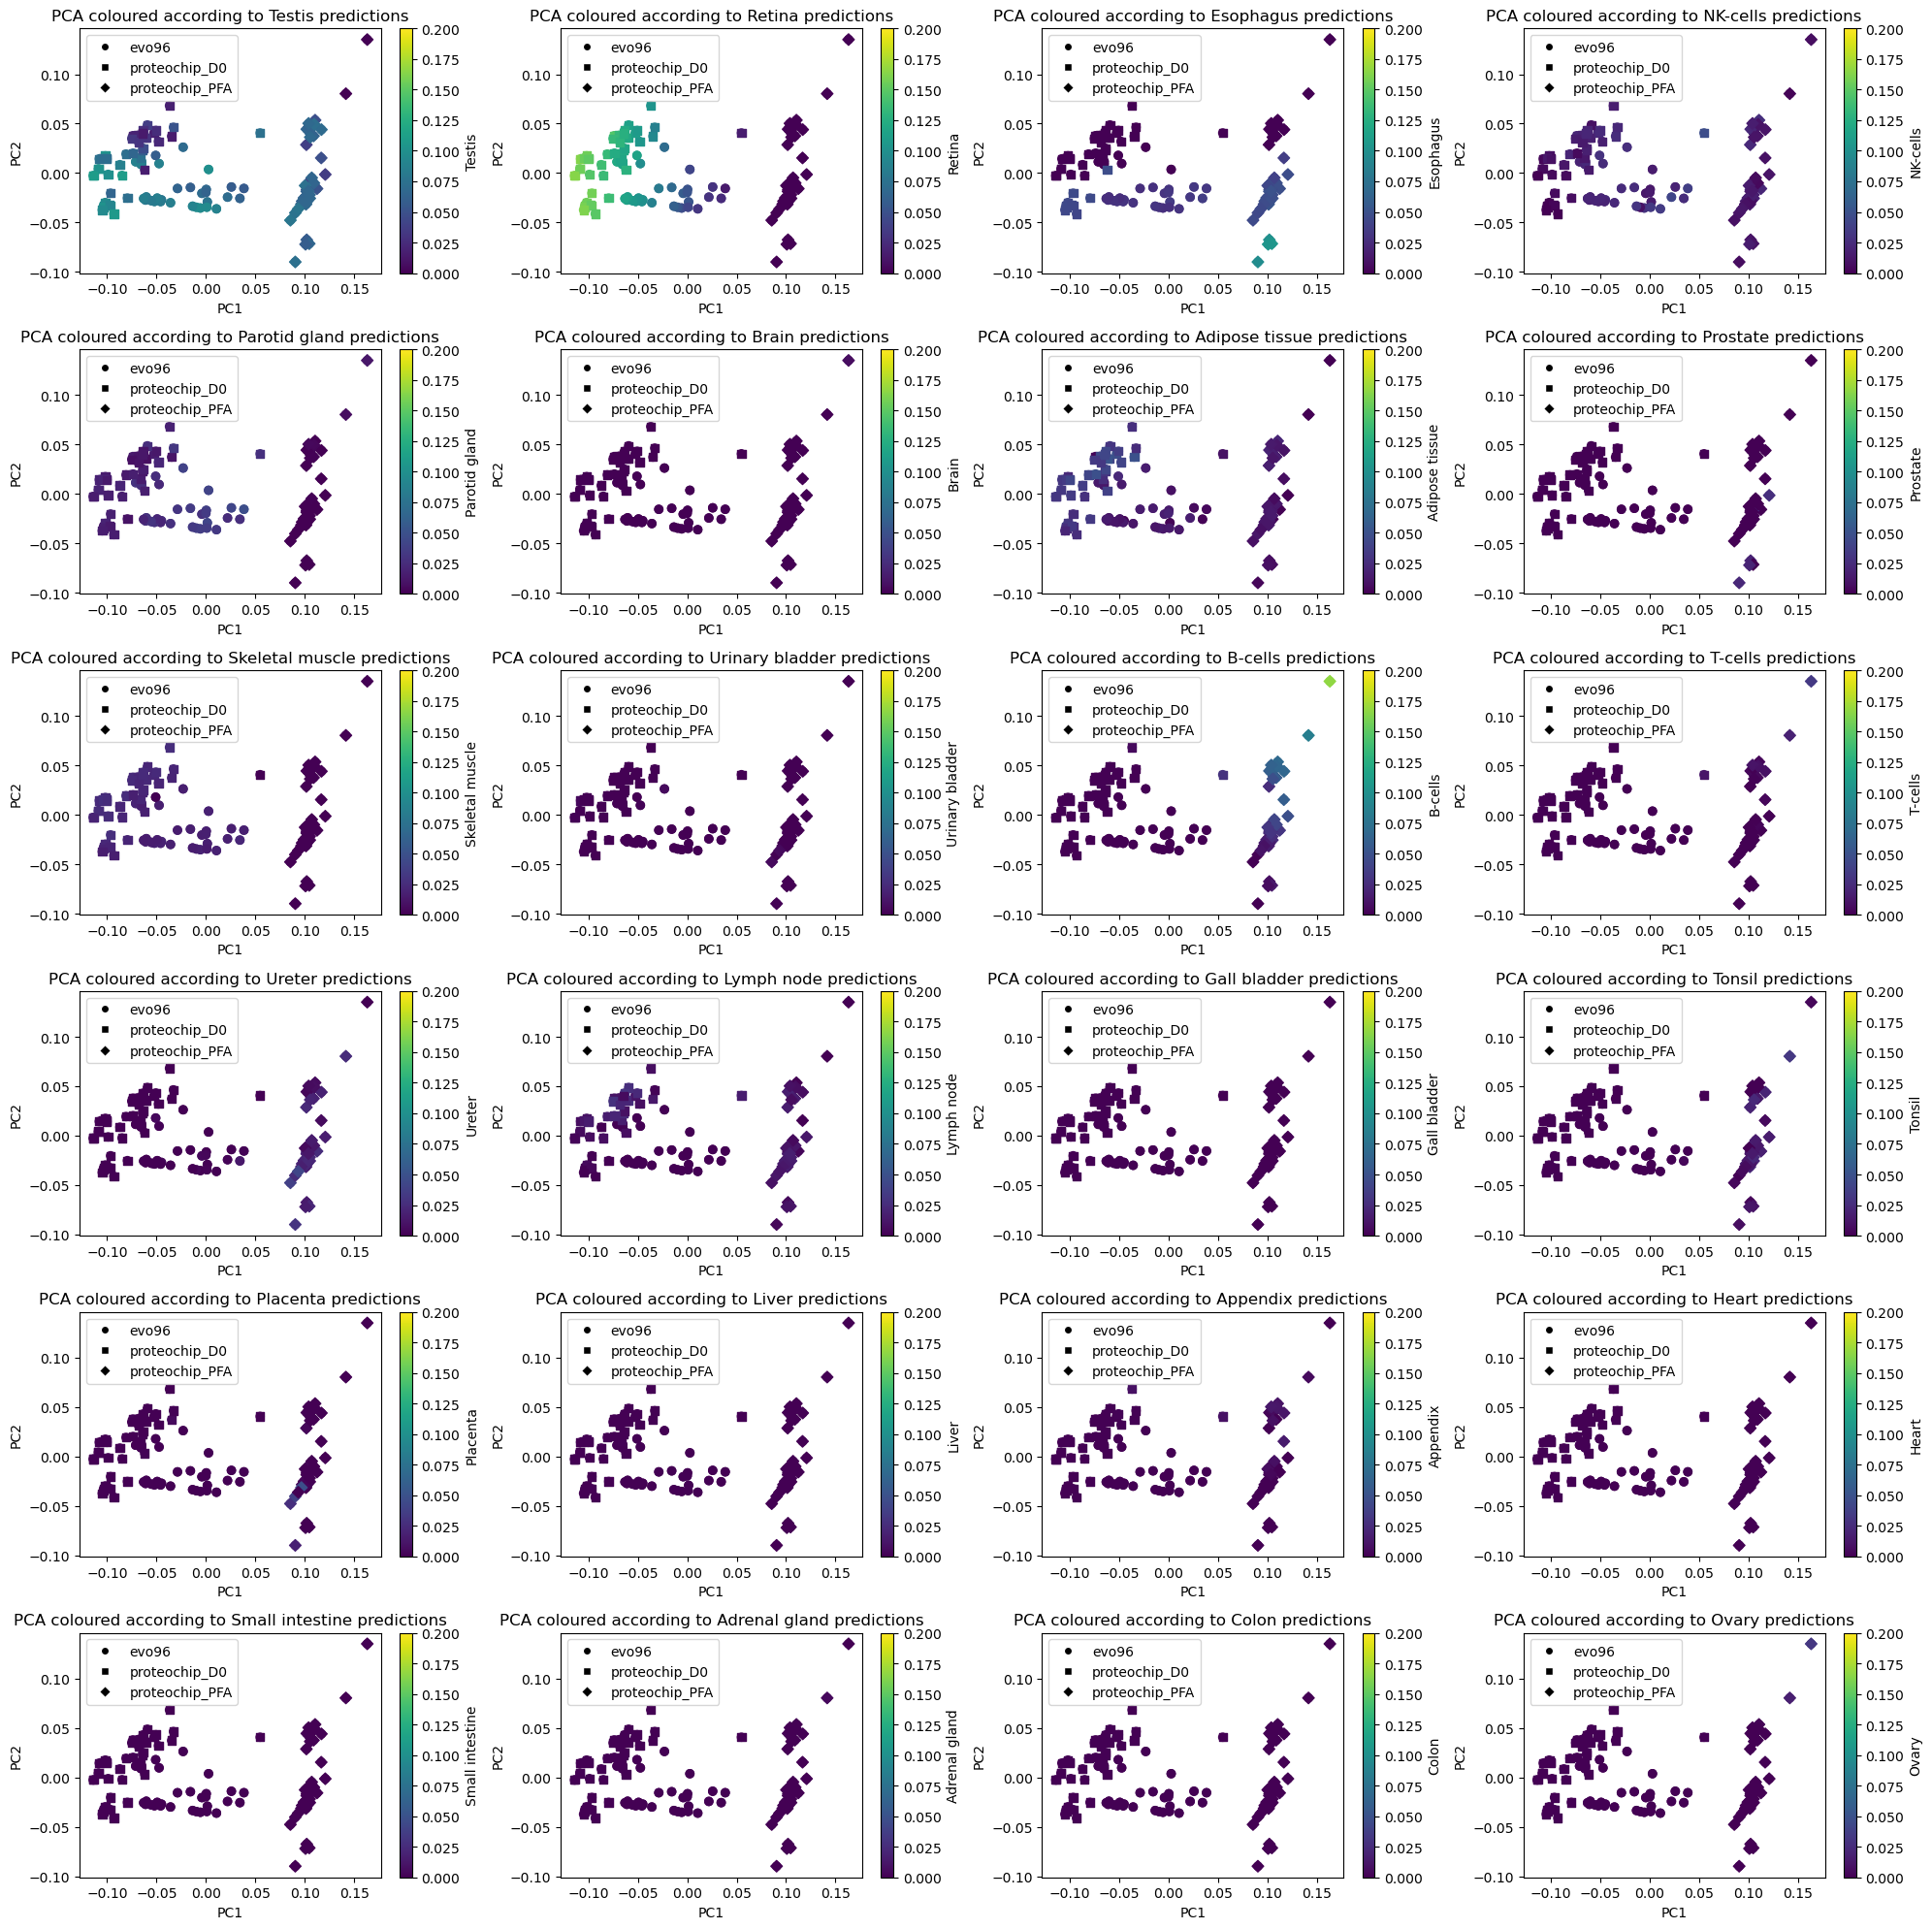

In [10]:
fig, axs = plt.subplots(6, 4, figsize=(20, 20))  # Create a figure with 6 rows and 4 columns

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(prediction_df.drop(columns=['sample', 'dataset', 'n_proteins']))
df_pca = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
df_pca[['Testis', 'Retina', 'Parotid gland', 'Brain', 'Adipose tissue', 'Prostate', 'NK-cells', 
'Skeletal muscle', 'Urinary bladder', 'B-cells', 'Esophagus', 'T-cells', 'Ureter', 
'Lymph node', 'Gall bladder', 'Tonsil', 'Placenta', 'Liver', 'Appendix', 'Heart', 
'Small intestine', 'Adrenal gland', 'Colon', 'Ovary']] = prediction_df.iloc[:, 3:]
df_pca[['sample', 'dataset']] = prediction_df[['sample', 'dataset']]

#add a column that states the number of proteins in the sample


tissues = ['Testis', 'Retina', 'Esophagus', 'NK-cells', 'Parotid gland', 'Brain', 'Adipose tissue', 'Prostate', 'Skeletal muscle', 'Urinary bladder', 'B-cells', 'T-cells', 'Ureter', 'Lymph node', 'Gall bladder', 'Tonsil', 'Placenta', 'Liver', 'Appendix', 'Heart', 'Small intestine', 'Adrenal gland', 'Colon', 'Ovary']

for i, t in enumerate(tissues):
    row = i // 4  # Calculate the row index
    col = i % 4  # Calculate the column index
    
    ax = axs[row, col]  # Select the current subplot
    
    scatter = ax.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca[t], cmap='viridis', vmin=0, vmax=0.2)
    
    # Change marker type according to the dataset column
    markers = ['o', 's', 'D']  # Define marker types for each dataset
    
    for j, dataset in enumerate(df_pca['dataset'].unique()):
        indices = df_pca['dataset'] == dataset
        ax.scatter(df_pca.loc[indices, 'PC1'], df_pca.loc[indices, 'PC2'], c=df_pca.loc[indices, t], cmap='viridis', marker=markers[j], label=dataset, vmin=0, vmax=0.2)
    
    # Add legend for marker type
    legend_markers = [plt.Line2D([0], [0], marker=marker, color='w', label=dataset, markerfacecolor='k') for marker, dataset in zip(markers, df_pca['dataset'].unique())]
    ax.legend(handles=legend_markers)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(t)
    
    # Add labels and title
    ax.set_title(f'PCA coloured according to {t} predictions')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()



Evo96 and D0 show strong Retina correlation. In PFA there seems to be a B-cell and esophagus prediction happening

# 2. Continuing with the proteochipD0 data, how different are individual cells?  

This dataset showed the most variability within this group. Are these single cells very different from each other?


In [11]:
#all proteins combined
df = pd.read_csv("proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv", sep='\t')
proteins = np.array(df[["Protein.Ids"]].values.tolist()).flatten()
# if it contains ';' split it and take both
proteins = [x.split(';') for x in proteins]
proteins = [item for sublist in proteins for item in sublist]
proteins = list(set(proteins))

#make a dataframe with the proteins as column names, only one row and all values 1
data = np.ones((1, len(proteins)))
predict_df = pd.DataFrame(data, columns=proteins)

test = MLMarker(predict_df.iloc[0:1,:], binary = True)
prediction = MLMarker.adjusted_shap_values_df(test, n_preds=100, penalty_factor=0.5).sum(axis=1).sort_values(ascending=False)
prediction = list(prediction.items())
print(prediction)

[('Retina', 0.15845565570897846), ('Testis', 0.1319278932480504), ('Esophagus', 0.06033337557130511), ('Skeletal muscle', 0.029335517059731215), ('Adipose tissue', 0.015504009221501764), ('Parotid gland', 0.008974157586282309), ('Prostate', 0.0070845175372368455), ('Liver', -0.007036610211952209), ('NK-cells', -0.007165690991754227), ('Lymph node', -0.008225821500330289), ('Brain', -0.01629796141772997), ('Urinary bladder', -0.016736130495972053), ('Small intestine', -0.018505588930524057), ('Gall bladder', -0.021280475753377427), ('Ureter', -0.022014625432353583), ('Appendix', -0.02241763362473133), ('Heart', -0.022980800201129584), ('Tonsil', -0.0266054273675866), ('Placenta', -0.026942516966158354), ('Adrenal gland', -0.033035720409886817), ('Colon', -0.03643667628844176), ('T-cells', -0.03818982923785052), ('Ovary', -0.04353132941980353), ('B-cells', -0.044212287683502945)]


In [12]:
import tqdm as tqdm
#individual samples
df = pd.read_csv("proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv", sep='\t')
df['Protein.Ids'] = df['Protein.Ids'].astype(str).str.split(';').str[0]
sub_df = df.set_index('Protein.Ids')
sub_df.drop(columns=['Protein.Group', 'Protein.Names', 'Genes', 'First.Protein.Description'], inplace=True)
sub_df = sub_df.T
sub_df.fillna(0, inplace=True)
sub_df = sub_df.astype(float)

# Create a new dataframe to store the predictions
prediction_df2 = pd.DataFrame(columns=['sample','Testis',  'Retina',  'Esophagus','Parotid gland',  'Brain',  'Adipose tissue',  'Skeletal muscle', 
'Prostate',  'NK-cells',  'B-cells', 'Urinary bladder',   'Lymph node',    'T-cells',  'Ureter',  
 'Gall bladder',  'Tonsil',  'Placenta',  'Liver',  'Appendix',  'Heart',  'Small intestine',  'Adrenal gland', 
 'Colon',  'Ovary'])

# Predict and add the predictions to the dataframe
for i in tqdm.tqdm(range(sub_df.shape[0])):
    
    test = MLMarker(sub_df.iloc[i:i+1,:], binary=True)
    prediction = MLMarker.adjusted_shap_values_df(test, n_preds=100).sum(axis=1).sort_values(ascending=False)
    prediction = list(prediction.items())
    prediction_df2.loc[i, 'sample'] = sub_df.index[i]
    for tissue, prob in prediction:
        prediction_df2.loc[i, tissue] = prob

#drop columns with only nan
prediction_df2.dropna(axis=1, how='all', inplace=True)


  0%|          | 0/44 [00:00<?, ?it/s]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


  2%|▏         | 1/44 [00:02<02:08,  2.98s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


  5%|▍         | 2/44 [00:05<02:04,  2.98s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


  7%|▋         | 3/44 [00:08<02:01,  2.97s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


  9%|▉         | 4/44 [00:11<01:59,  2.98s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 11%|█▏        | 5/44 [00:14<01:56,  2.98s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 14%|█▎        | 6/44 [00:17<01:53,  2.99s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 16%|█▌        | 7/44 [00:20<01:50,  2.99s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 18%|█▊        | 8/44 [00:23<01:47,  2.98s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 20%|██        | 9/44 [00:26<01:44,  2.99s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 23%|██▎       | 10/44 [00:29<01:41,  2.99s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 25%|██▌       | 11/44 [00:33<01:41,  3.06s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 27%|██▋       | 12/44 [00:36<01:37,  3.05s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 30%|██▉       | 13/44 [00:39<01:34,  3.05s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 32%|███▏      | 14/44 [00:42<01:32,  3.07s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 34%|███▍      | 15/44 [00:45<01:28,  3.05s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 36%|███▋      | 16/44 [00:48<01:25,  3.06s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 39%|███▊      | 17/44 [00:51<01:22,  3.05s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 41%|████      | 18/44 [00:54<01:19,  3.04s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 43%|████▎     | 19/44 [00:57<01:16,  3.04s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 45%|████▌     | 20/44 [01:00<01:12,  3.03s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 48%|████▊     | 21/44 [01:03<01:09,  3.01s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 50%|█████     | 22/44 [01:06<01:06,  3.01s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 52%|█████▏    | 23/44 [01:09<01:03,  3.01s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 55%|█████▍    | 24/44 [01:12<01:00,  3.01s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 57%|█████▋    | 25/44 [01:15<00:57,  3.02s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 59%|█████▉    | 26/44 [01:18<00:55,  3.09s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 61%|██████▏   | 27/44 [01:21<00:52,  3.07s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 64%|██████▎   | 28/44 [01:24<00:49,  3.07s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 66%|██████▌   | 29/44 [01:27<00:45,  3.05s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 68%|██████▊   | 30/44 [01:30<00:42,  3.06s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 70%|███████   | 31/44 [01:33<00:39,  3.06s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 73%|███████▎  | 32/44 [01:36<00:36,  3.05s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 75%|███████▌  | 33/44 [01:40<00:33,  3.06s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 77%|███████▋  | 34/44 [01:43<00:30,  3.05s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 80%|███████▉  | 35/44 [01:46<00:27,  3.06s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 82%|████████▏ | 36/44 [01:49<00:24,  3.05s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 84%|████████▍ | 37/44 [01:52<00:21,  3.04s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 86%|████████▋ | 38/44 [01:55<00:18,  3.03s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 89%|████████▊ | 39/44 [01:58<00:15,  3.04s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 91%|█████████ | 40/44 [02:01<00:12,  3.03s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 93%|█████████▎| 41/44 [02:04<00:09,  3.03s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 95%|█████████▌| 42/44 [02:07<00:06,  3.08s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 98%|█████████▊| 43/44 [02:10<00:03,  3.06s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


100%|██████████| 44/44 [02:13<00:00,  3.03s/it]


In [13]:
prediction_df2

,sample,Testis,Retina,Esophagus,Parotid gland,Brain,Adipose tissue,Skeletal muscle,Prostate,NK-cells,...,Gall bladder,Tonsil,Placenta,Liver,Appendix,Heart,Small intestine,Adrenal gland,Colon,Ovary
0,TU014892CK_Slot1-01_1_3148.d,0.101524,0.196925,0.012801,0.004329,-0.020159,0.04905,0.052207,0.008802,-0.062874,...,0.018779,-0.035637,-0.004712,0.017562,-0.017506,0.00584,0.005578,-0.018907,-0.028223,-0.05802
1,TU014893CK_Slot1-02_1_3149.d,0.09034,0.192457,0.051755,0.004174,-0.019919,0.056317,0.05193,0.006656,-0.055145,...,0.01703,-0.032152,-0.00632,0.006207,-0.022235,0.001485,0.001523,-0.020039,-0.029996,-0.059558
2,TU014894CK_Slot1-03_1_3150.d,0.092504,0.189802,0.053905,0.00528,-0.017359,0.051324,0.049427,0.00521,-0.06271,...,0.018822,-0.034901,-0.004365,0.009031,-0.019815,0.00611,0.004537,-0.016798,-0.028336,-0.058805
3,TU014895CK_Slot1-04_1_3151.d,0.071771,0.197353,0.014464,0.007715,-0.019264,0.052499,0.054928,0.009692,-0.05957,...,0.017588,-0.031351,-0.002262,0.016392,-0.016951,0.005171,0.005273,-0.018405,-0.027562,-0.057691
4,TU014896CK_Slot1-05_1_3152.d,0.097562,0.191312,0.012198,0.005058,-0.021395,0.056066,0.051421,0.011258,-0.051887,...,0.01992,-0.035494,-0.004337,0.010354,-0.018233,0.004165,0.005017,-0.015917,-0.028074,-0.058809
5,TU014897CK_Slot1-06_1_3153.d,0.096326,0.191568,0.053798,0.005549,-0.019486,0.045899,0.048968,0.007441,-0.054938,...,0.0167,-0.032442,-0.009582,0.016921,-0.022151,0.004836,0.002553,-0.024361,-0.029581,-0.05865
6,TU014898CK_Slot1-07_1_3154.d,0.089678,0.187812,0.049833,0.006202,-0.020498,0.045887,0.050256,0.007563,-0.058933,...,0.014951,-0.032687,-0.007006,0.019614,-0.018346,0.002732,0.002855,-0.020126,-0.029519,-0.055655
7,TU014899CK_Slot1-08_1_3155.d,0.087804,0.186705,0.052061,0.005697,-0.020903,0.05003,0.048481,0.009336,-0.060168,...,0.019768,-0.034891,-0.005764,0.014125,-0.019722,0.004086,0.002301,-0.020246,-0.027919,-0.055694
8,TU014900CK_Slot1-09_1_3156.d,0.067309,0.19101,0.052906,0.007077,-0.022428,0.04648,0.056153,0.007621,-0.056705,...,0.017119,-0.032437,-0.005088,0.016525,-0.01782,0.003486,0.00487,-0.02156,-0.028186,-0.056069
9,TU014901CK_Slot1-10_1_3157.d,0.089635,0.175915,0.013969,0.005988,-0.014772,0.05775,0.053844,0.016498,-0.057882,...,0.01677,-0.03214,0.004379,0.018537,-0.01852,0.008411,0.009211,-0.015574,-0.026335,-0.060656


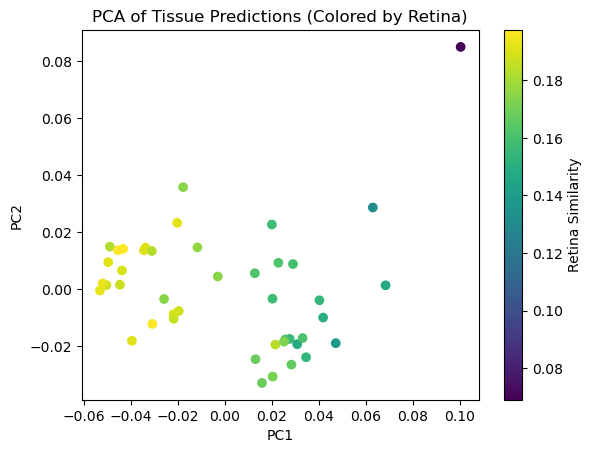

In [14]:
# Make a PCA and color the samples according to Retina similarity
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(prediction_df2.drop(columns=['sample']))
df_pca = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
df_pca[['Retina']] = prediction_df2[['Retina']]
df_pca[['sample']] = prediction_df2[['sample']]

# Plot the reduced data with color according to 'Retina' column
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Retina'], cmap='viridis')

# Add colorbar
cbar = plt.colorbar()
cbar.set_label('Retina Similarity')

# Add labels and title
plt.title('PCA of Tissue Predictions (Colored by Retina)')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Show the plot
plt.show()


Follow up analysis:   
Which proteins pop up more and more that make it more Retina like?

# 3. PFA dataset: why is this one so different?

1. There are less proteins which seem to be less tissue specific  (except for Esophagus and b-cells)   
Sample prep induced

2764
3951
861


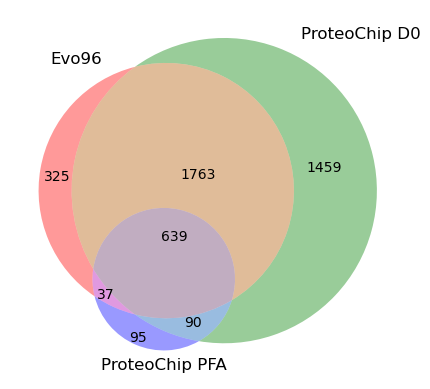

In [15]:
from matplotlib_venn import venn3
for i in protein_lists:
    print(len(i))
# Create the Venn diagram
venn3(protein_lists, ('Evo96', 'ProteoChip D0', 'ProteoChip PFA'))

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gprofiler import GProfiler

# Initialize g:Profiler
gp = GProfiler(return_dataframe=True)

# Dictionary to store GO terms and p-values for each tissue
go_dict = {}


# Perform GO enrichment analysis for each tissue and store p-values
for prots, name in zip(protein_lists, ['Evo96', 'ProteoChip D0', 'ProteoChip PFA']):
    results = gp.profile(organism='hsapiens', query=list(prots), sources=['GO:BP', 'GO:MF', 'GO:CC', 'HPA'])
    results = results[results['p_value']< 0.01]
    # Store results in the dictionary: {tissue: {GO_term: p-value}}
    go_dict[name] = dict(zip(results['name'], results['p_value']))

go_df = pd.DataFrame.from_dict(go_dict, orient='columns').fillna(0)
go_df.tail()



,Evo96,ProteoChip D0,ProteoChip PFA
cell killing,0.0,0.0,0.006319
small intestine; endocrine cells[High],0.0,0.0,0.007001
defense response to bacterium,0.0,0.0,0.007634
myosin V binding,0.0,0.0,0.008649
positive regulation of intrinsic apoptotic signaling pathway,0.0,0.0,0.008811


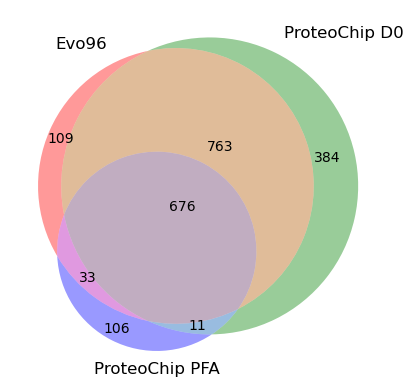

In [17]:
#make a venn diagram of go_dict terms
venn3([set(go_dict['Evo96'].keys()), set(go_dict['ProteoChip D0'].keys()), set(go_dict['ProteoChip PFA'].keys())], ('Evo96', 'ProteoChip D0', 'ProteoChip PFA'))

In [18]:
pfa = pd.read_csv("/home/compomics/git/MLMarker/Projects/organoids_pauline/peptides/pfa_report_organoides_042024_fixes.pr_matrix.tsv", sep='\t')
pfa_sequences = pfa['Stripped.Sequence'].values

ev096 = pd.read_csv("/home/compomics/git/MLMarker/Projects/organoids_pauline/peptides/evo96_report_organoids_culture_15042024_diann181.pr_matrix.tsv", sep='\t')
ev096_sequences = ev096['Stripped.Sequence'].values

d0 = pd.read_csv("/home/compomics/git/MLMarker/Projects/organoids_pauline/peptides/d0_report_organoids_culture_15042024_diann181.pr_matrix.tsv", sep='\t')
d0_sequences = d0['Stripped.Sequence'].values


In [19]:
len(pfa_sequences), len(ev096_sequences), len(d0_sequences)

(4172, 13636, 27870)

In [20]:
def calculate_hydrophobicity(sequence):
    """Calculate the average hydrophobicity of a sequence based on the amino acid composition and the hydrophobicity scale 
    from https://web.expasy.org/protscale/ GRAVY score sum of hydrophaty value of each residue/number of residues"""
    gravy_dict = {'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5, 'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5, 'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6, 'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2}
    gravy = sum([gravy_dict[aa] for aa in sequence]) / len(sequence)
    return gravy
def calculate_molecular_weight(sequence):
    molweight_dict = {'A': 71.08, 'R': 156.19, 'N': 114.11, 'D': 115.09, 'C': 103.15, 'Q': 128.14, 'E': 129.12, 'G': 57.05, 'H': 137.14, 'I': 113.16, 'L': 113.16, 'K': 128.17, 'M': 131.19, 'F': 147.18, 'P': 97.12, 'S': 87.08, 'T': 101.11, 'W': 186.21, 'Y': 163.18, 'V': 99.13}
    molweight = sum([molweight_dict[aa] for aa in sequence])
    return molweight
def calculate_instability_index(sequence):
    instability_values = {
        'A': 1.0, 'R': -2.5, 'N': 0.9, 'D': -0.5, 'C': -1.0, 'Q': -1.2, 'E': -1.2, 'G': 0.3, 'H': -0.6,
        'I': -1.0, 'L': -1.2, 'K': 1.0, 'M': -1.2, 'F': -2.0, 'P': 0.7, 'S': 0.3, 'T': 0.2, 'W': -1.2, 'Y': -2.5, 'V': -1.2
    }
    instability_index = sum([instability_values[aa] for aa in sequence])
    return instability_index
def bulkiness(sequence):
    bulki_dict = {'A': 11.5, 'R': 14.28, 'N': 12.82, 'D': 11.68, 'C': 13.45, 'Q': 14.45, 'E': 13.57, 'G': 3.4, 'H': 13.69, 'I': 21.4, 'L': 21.4, 'K': 15.71, 'M': 16.25, 'F': 19.8, 'P': 17.43, 'S': 9.47, 'T': 15.77, 'W': 21.67, 'Y': 18.03, 'V': 21.57}

def calculate_isoelectric_point(sequence):
    pka_values = {'C-term': 3.1, 'N-term': 8.0, 'C': 8.5, 'D': 3.9, 'E': 4.1, 'H': 6.5, 'K': 10.8, 'R': 12.5, 'Y': 10.1}
    positive_residues = ['H', 'K', 'R', 'N-term']
    negative_residues = ['D', 'E', 'C', 'Y', 'C-term']

    def net_charge_at_pH(pH):
        pos_charge = sum([10**pka_values[aa] / (10**pka_values[aa] + 10**pH) for aa in positive_residues if aa in sequence])
        neg_charge = sum([10**pH / (10**pka_values[aa] + 10**pH) for aa in negative_residues if aa in sequence])
        return pos_charge - neg_charge

    # Binary search to find the pI where net charge is approximately 0
    pH_low, pH_high = 0, 14
    while pH_high - pH_low > 0.01:
        pH_mid = (pH_low + pH_high) / 2.0
        if net_charge_at_pH(pH_mid) > 0:
            pH_low = pH_mid
        else:
            pH_high = pH_mid
    return round((pH_low + pH_high) / 2.0, 2)


In [21]:
def plot_score(score_type, pfa_sequences, ev096_sequences, d0_sequences):
    if score_type == 'GRAVY':
        calculate_score = calculate_hydrophobicity
        title = 'GRAVY score'
    elif score_type == 'Molecular Weight':
        calculate_score = calculate_molecular_weight
        title = 'Molecular Weight'
    elif score_type == 'Instability Index':
        calculate_score = calculate_instability_index
        title = 'Instability Index'
    elif score_type == 'Isoelectric Point':
        calculate_score = calculate_isoelectric_point
        title = 'Isoelectric Point'
    else:
        raise ValueError('Invalid score type')
    pfa_score = []
    ev096_score = []
    d0_score = []
    for i in [pfa_sequences, ev096_sequences, d0_sequences]:
        for seq in i:
            score = calculate_score(seq)
            if len(i) == len(pfa_sequences):
                pfa_score.append(score)
            elif len(i) == len(ev096_sequences):
                ev096_score.append(score)
            else:
                d0_score.append(score)
    #boxplot of the three score distributions
    sns.violinplot(data=[pfa_score, ev096_score, d0_score])
    plt.xticks([0, 1, 2], ['PFA', 'Evo96', 'D0'])
    plt.ylabel(title)
    plt.title(title)
    plt.show()

PFA remaining proteins highly abundant <=> other sample preps   
C

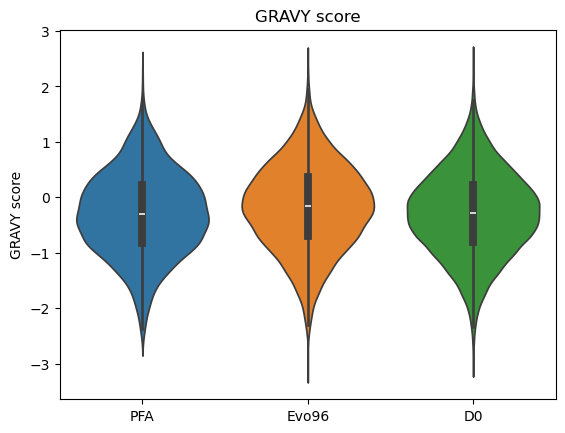

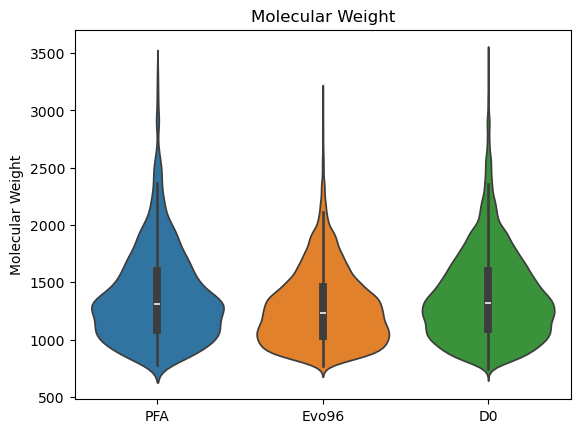

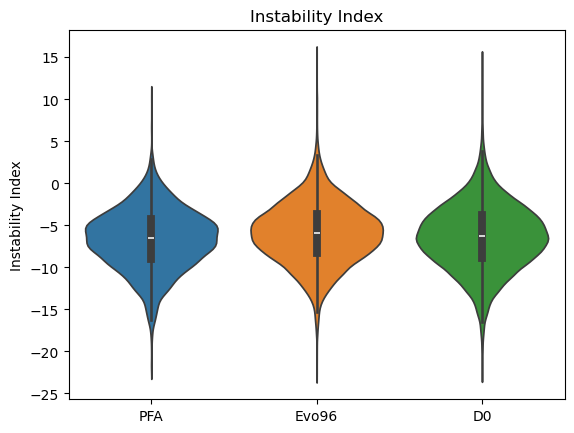

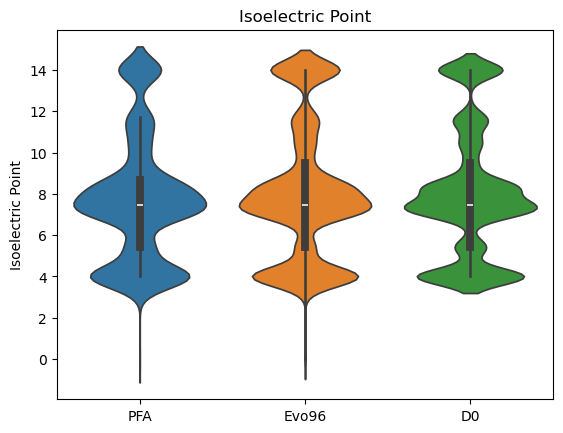

In [22]:
for i in ['GRAVY', 'Molecular Weight', 'Instability Index', 'Isoelectric Point']:
    plot_score(i, pfa_sequences, ev096_sequences, d0_sequences)